# **Линейные модели**

## Содержание
1. Описание датасета. Загрузка данных.
2. Разделение выборки на тестовую и обучающую.
3. Обучение моделей. 
    + Линейной модели. 
    + SVM.
    + Дерево решений.
4. Оценка качества моделей.
5. График важности признаков дерева решений.
6. Визуализация дерева решений. Правила дерева решений

## 1. Описание датасета

Возьмем стандартный учебный датасет из Sklearn - The Iris Dataset[https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html]

#### Импорт библиотек

In [141]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from scipy.optimize import fmin_tnc

#### Загрузка данных

In [78]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = pd.Series(iris.target)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


Text(0, 0.5, 'petal width')

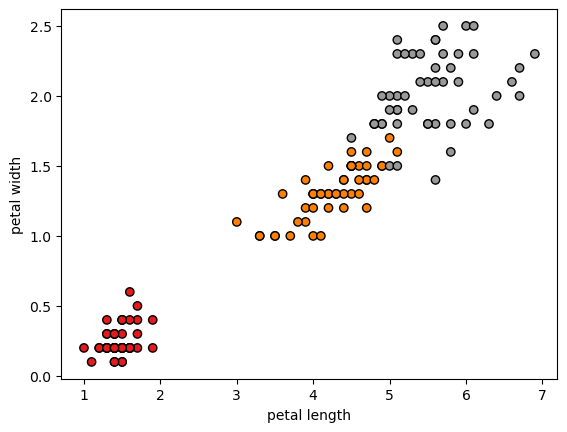

In [80]:
# Посмотрим распределение наших данных
X = df['petal length (cm)']
Y = df['petal width (cm)']
plt.scatter(X, Y, c=df.target, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("petal length")
plt.ylabel("petal width")


<AxesSubplot:>

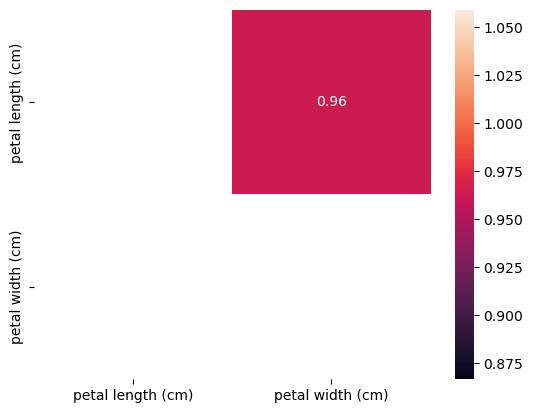

In [81]:
data = df[['petal length (cm)', 'petal width (cm)']]
mask = np.zeros_like(data.corr())
mask[np.tril_indices_from(mask)] = True
sns.heatmap(data.corr(method='pearson'), mask=mask, annot=True, fmt='.2f')

Можем увидеть почти полную корреляцию между двумя нашими значениями. Зависимость близкая к линейной, коэффициент корреляции = 0,96

## 2. Разделение выборки на тестовую и обучающую.

Выполним разбиение с поомщью функции sklearn.model_selection.train_test_split, объем тестовой выборки зададим равным 0.2 от общего объема.

In [82]:
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(X, Y, random_state=42, test_size = 0.2)


Посмотрим насколько репрезентативны выборки

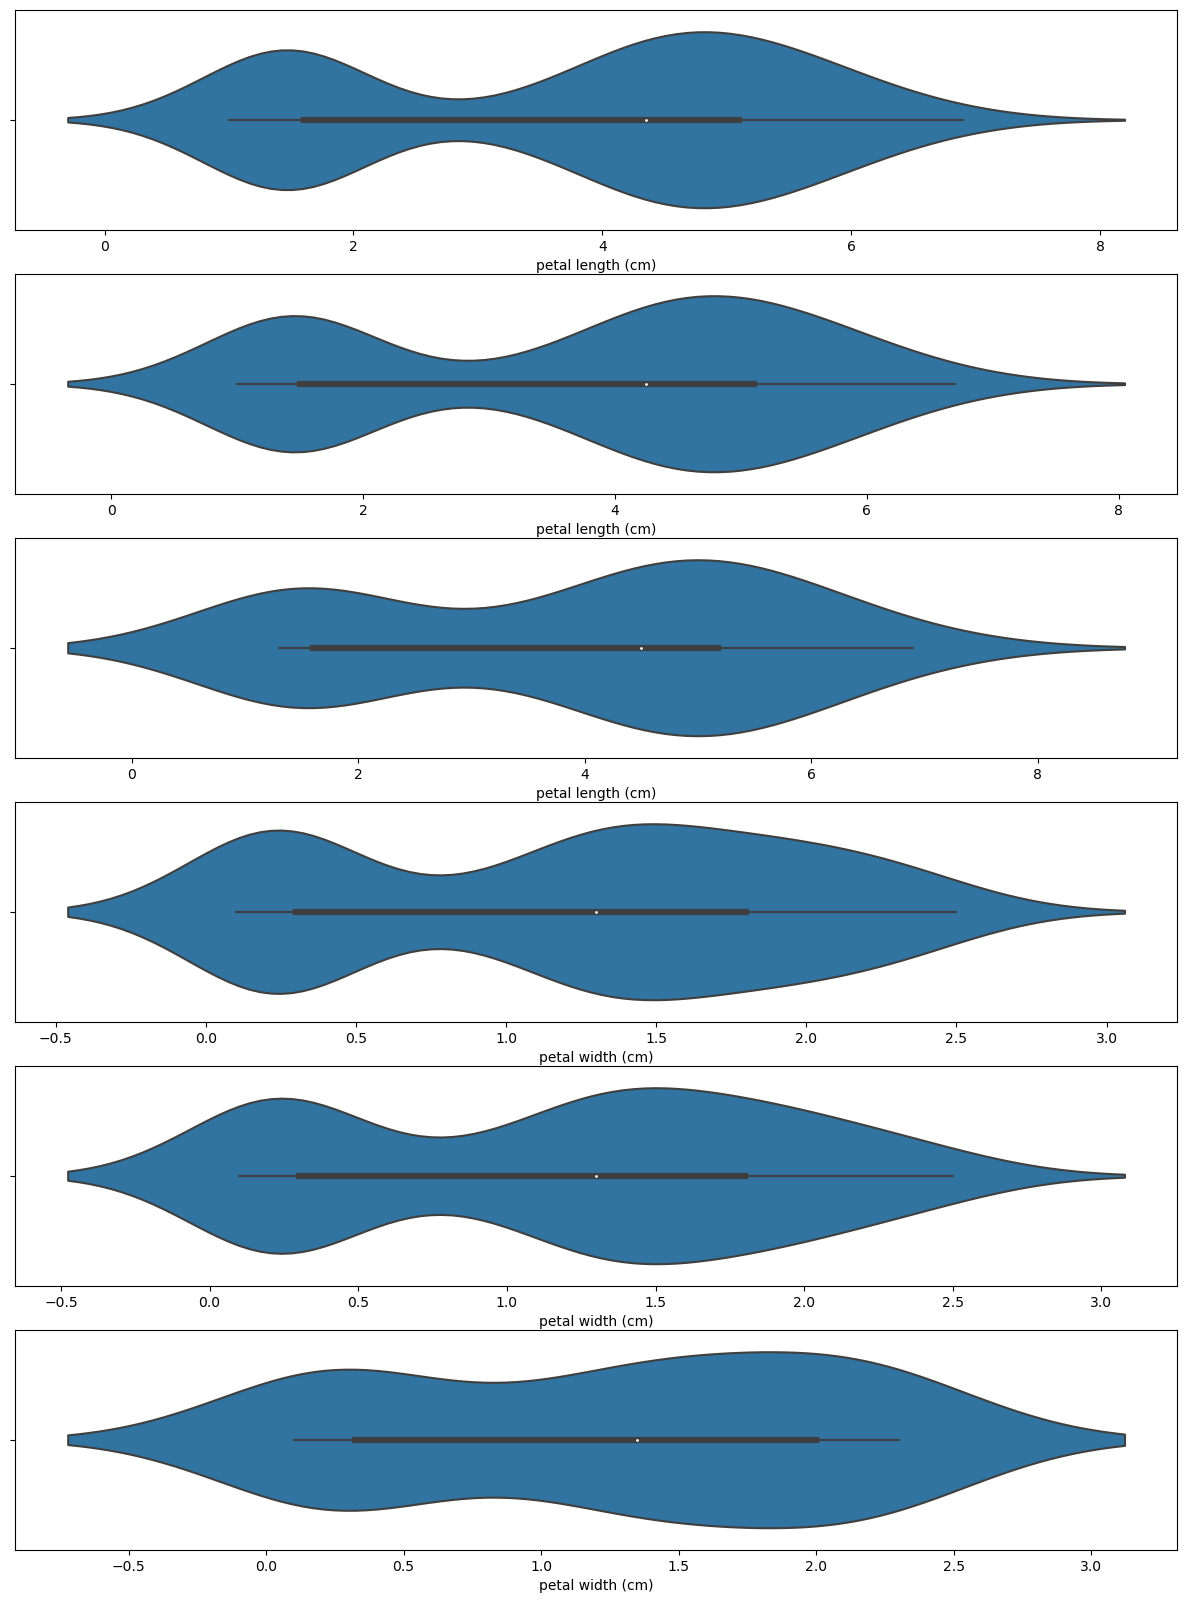

In [83]:
fig, ax = plt.subplots(6, 1, figsize=(15, 20))
sns.violinplot(ax=ax[0], x=X)
sns.violinplot(ax=ax[1], x=x_training_data)
sns.violinplot(ax=ax[2], x=x_test_data)
sns.violinplot(ax=ax[3], x=Y)
sns.violinplot(ax=ax[4], x=y_training_data)
sns.violinplot(ax=ax[5], x=y_test_data)

plt.show()

## 3. Обучение моделей

Линейная модель, которая основывается на предположении о существовании линейной зависимости между нашими данными(длиной и шириной лепестков)

In [84]:
# Аналитическое вычисление коэффициентов регрессии для формулы среднее Y = b0 + b1*(x среднее)
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-x_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [85]:
b0, b1 = analytic_regr_coef(x_training_data, y_training_data)
b0, b1

(-0.35666804105655436, 0.41323829366454945)

In [86]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [87]:
y_array_regr = y_regr(x_training_data, b0, b1)

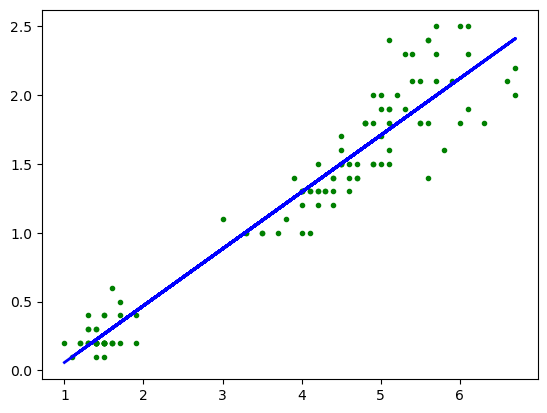

In [88]:
plt.plot(x_training_data, y_training_data, 'g.')
plt.plot(x_training_data, y_array_regr, 'b', linewidth=2.0)
plt.show()

Мы аналитически нашли коэффициенты для уравнения нашей зависимости. Зададим функцию потерь как квадрат ошибки между истинными(данными) и предсказанными(лежащими на прямой).

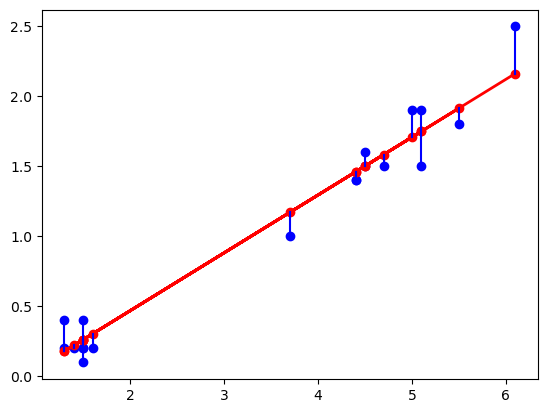

In [89]:
# Синими отрезками показаны ошибки между 
# истинными и предсказанными значениями
plt.plot(x_training_data[1:20], y_training_data[1:20], 'bo')
plt.plot(x_training_data[1:20], y_array_regr[1:20], '-ro', linewidth=2.0)

for i in range(len(x_training_data[1:20])):
    x1 = x_training_data[1:20].iloc[i]
    y1 = y_training_data[1:20].iloc[i]
    y2 = y_array_regr[1:20][i]
    plt.plot([x1,x1],[y1,y2],'b-')

plt.show()

Можем увидеть некоторые примеры ошибок модели в предсказании. Для решения задачи оптимизации в методе наименьших квадратов - используем метод градиентного спуска. Будем менять наши значения коэффициентов b0, b1, вычитая из них в цикле частную производную функцию потерь по каждой из переменных, умноженную на шаг λ(learning rate), то-есть двигаясь с этим шагом в направлении антиградиента. Критерием остановки цикла будет попадание модуля разности коэффициентов b этогои прошлого шага цикла в определенный эпсилон ϵ.

In [90]:
def gradient_descent(x_array : np.ndarray,
                     y_array : np.ndarray,
                     b0_0 : float,
                     b1_0 : float,
                     epochs : int,
                     learning_rate : float = 0.001
                    ) -> tuple[float, float]:
    # Значения для коэффициентов по умолчанию
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs): 
        # Вычисление новых предсказанных значений
        y_pred = b1 * x_array + b0
        type(y_pred)
        # Расчет градиентов
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        # Изменение значений коэффициентов:
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    # Результирующие значения
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred

b0 = -0.35666804105655436 - (теоретический), -0.3529413743898877 - (градиентный спуск)
b1 = 0.41323829366454945 - (теоретический), -0.06982853966878388 - (градиентный спуск)
MSE = 3.938010997050952


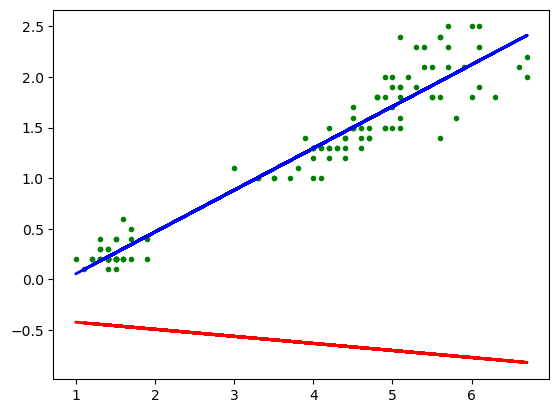

In [91]:
grad_b0, grad_b1, grad_y_pred = gradient_descent(x_training_data, y_training_data, b0, b1-0.5, 1)
print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
print('MSE = {}'.format(mean_squared_error(y_array_regr, grad_y_pred)))
plt.plot(x_training_data, y_training_data, 'g.')
plt.plot(x_training_data, y_array_regr, 'b', linewidth=2.0)
plt.plot(x_training_data, grad_y_pred, 'r', linewidth=2.0)
plt.show()

b0 = -0.35666804105655436 - (теоретический), -0.2571552223536189 - (градиентный спуск)
b1 = 0.41323829366454945 - (теоретический), 0.37768151651081233 - (градиентный спуск)
MSE = 0.004938599421556803


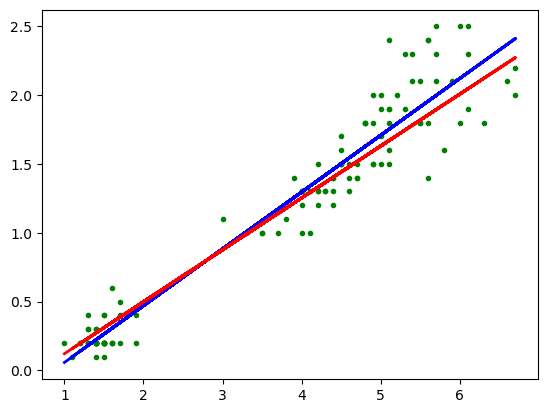

In [92]:
grad_b0, grad_b1, grad_y_pred = gradient_descent(x_training_data, y_training_data, b0, b1-0.5, 100)
print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
print('MSE = {}'.format(mean_squared_error(y_array_regr, grad_y_pred)))
plt.plot(x_training_data, y_training_data, 'g.')
plt.plot(x_training_data, y_array_regr, 'b', linewidth=2.0)
plt.plot(x_training_data, grad_y_pred, 'r', linewidth=2.0)
plt.show()

Можно заметить, насколько сильно сходимость алгоритма зависит от заданных параметров.  

### Использование класса LinearRegression библиотеки scikit-learn.

In [93]:
# Обучим линейную регрессию и сравним коэффициенты с рассчитанными ранее
reg1 = LinearRegression().fit(x_training_data.to_numpy().reshape(-1, 1), y_training_data.to_numpy().reshape(-1, 1))
(b1, reg1.coef_), (b0, reg1.intercept_)

((0.41323829366454945, array([[0.41323829]])),
 (-0.35666804105655436, array([-0.35666804])))

#### Стохастический градиентный спуск
Пердполагает, что обучение на каждом шаге (эпохе) происходит не на полном наборе данных а на одном случайно выбранном примере. 
Используем SGDRegressor.

In [94]:
reg2 = SGDRegressor().fit(x_training_data.to_numpy().reshape(-1, 1), y_training_data)
(b1, reg2.coef_), (b0, reg2.intercept_)

((0.41323829366454945, array([0.35364892])),
 (-0.35666804105655436, array([-0.10210294])))

### Использование регуляризации
Это метод борьбы с переобучением. Используем Elastic net. В библиотеке scikit-learn используются отдельные классы для различных вариантов регуляризации:

In [95]:
from sklearn.linear_model import Lasso
reg3 = Lasso().fit(x_training_data.to_numpy().reshape(-1, 1), y_training_data)
(b1, reg3.coef_), (b0, reg3.intercept_)

((0.41323829366454945, array([0.08484425])),
 (-0.35666804105655436, 0.8671470949898016))

In [96]:
from sklearn.linear_model import Ridge
reg4 = Ridge().fit(x_training_data.to_numpy().reshape(-1, 1), y_training_data)
(b1, reg4.coef_), (b0, reg4.intercept_)

((0.41323829366454945, array([0.41211051])),
 (-0.35666804105655436, -0.35246514877497614))

In [97]:
from sklearn.linear_model import ElasticNet
reg5 = ElasticNet().fit(x_training_data.to_numpy().reshape(-1, 1), y_training_data)
(b1, reg5.coef_), (b0, reg5.intercept_)

((0.41323829366454945, array([0.21391677])),
 (-0.35666804105655436, 0.386136820231868))

## Нелинейная регрессия

Если распределение наших данных сложнее линейного, то мы можем апроксимировать их нелинейной моделью

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
poly_model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                       ('linear', LinearRegression(fit_intercept=False))])
poly_model.fit(x_training_data.to_numpy().reshape(-1, 1), y_training_data)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])

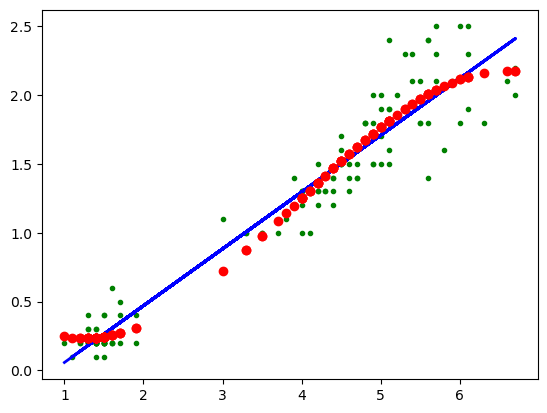

In [99]:
poly_y_pred = poly_model.predict(x_training_data.to_numpy().reshape(-1, 1))
plt.plot(x_training_data, y_training_data, 'g.')
plt.plot(x_training_data, y_array_regr, 'b', linewidth=2.0)
plt.plot(x_training_data, poly_y_pred, 'ro')
plt.show()

In [100]:
# Степени полинома
poly_model.named_steps['linear'].coef_, poly_model.named_steps['linear'].intercept_

(array([ 0.61492867, -0.6488705 ,  0.30609464, -0.02604583]), 0.0)

In [101]:
def test_poly_model(degree=3):
    poly_model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                       ('linear', LinearRegression(fit_intercept=False))])
    poly_model.fit(x_training_data.to_numpy().reshape(-1, 1), y_training_data)
    poly_y_pred = poly_model.predict(x_training_data.to_numpy().reshape(-1, 1))
    
    plt.plot(x_training_data, y_training_data, 'g.')
    plt.plot(x_training_data, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_training_data, poly_y_pred, 'ro')
    plt.show()
    
    print('Степени полинома - {}'.format(poly_model.named_steps['linear'].coef_))


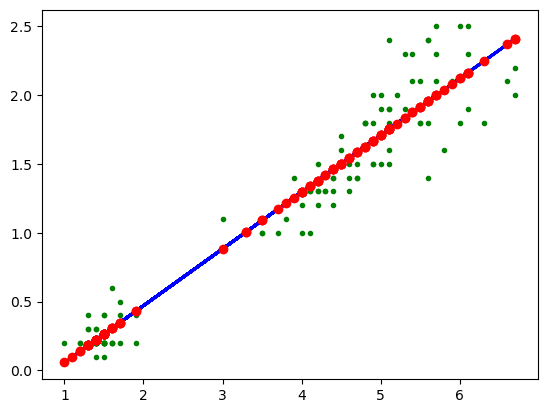

Степени полинома - [-0.35666804  0.41323829]


In [102]:
test_poly_model(degree=1)

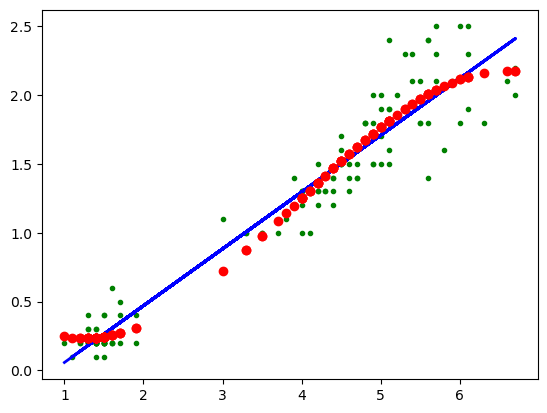

Степени полинома - [ 0.61492867 -0.6488705   0.30609464 -0.02604583]


In [103]:
test_poly_model(degree=3)

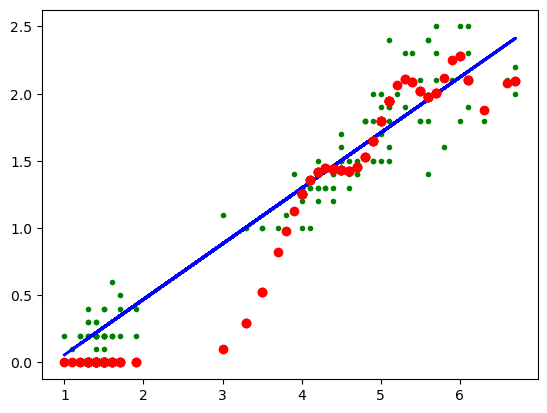

Степени полинома - [ 4.13552234e-11 -1.32075416e-11 -9.53294444e-14  2.57465316e-15
  8.47111911e-17  3.87264521e-16  1.20286340e-15  3.80287351e-15
  1.20251558e-14  3.76258929e-14  1.15636305e-13  3.46904840e-13
  1.00949616e-12  2.82922002e-12  7.56978068e-12  1.91174038e-11
  4.48772222e-11  9.57849140e-11  1.79644945e-10  2.78961596e-10
  3.15358210e-10  1.59372014e-10 -1.75862081e-10 -2.34787516e-10
  2.76773745e-10 -1.23244119e-10  3.05332154e-11 -4.59493642e-12
  4.19872515e-13 -2.15294421e-14  4.76995261e-16]


In [104]:
test_poly_model(degree=30)

### Логистическая регрессия

In [105]:
iris_x_ds_lr = df[['petal length (cm)', 'sepal length (cm)']]
iris_x_ds_lr['x0'] = 1
iris_x_ds_lr['target'] = iris.target
iris_x_ds_lr.head()

C:\Users\kozlo\AppData\Local\Temp\ipykernel_13052\458533915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris_x_ds_lr['x0'] = 1
C:\Users\kozlo\AppData\Local\Temp\ipykernel_13052\458533915.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris_x_ds_lr['target'] = iris.target


,petal length (cm),sepal length (cm),x0,target
0,1.4,5.1,1,0
1,1.4,4.9,1,0
2,1.3,4.7,1,0
3,1.5,4.6,1,0
4,1.4,5.0,1,0


In [128]:
def convert_target_to_binary(array:np.ndarray, target:int) -> np.ndarray:
    # Если целевой признак совпадает с указанным, то 1 иначе 0
    res = [1 if x==target else 0 for x in array]
    return res

In [129]:
bin_iris_y = convert_target_to_binary(iris.target, 0)

In [134]:
iris_x_ds_lr['target_bin'] = bin_iris_y
iris_x_ds_lr[47:]

,petal length (cm),sepal length (cm),x0,target,target_bin
47,1.4,4.6,1,0,1
48,1.5,5.3,1,0,1
49,1.4,5.0,1,0,1
50,4.7,7.0,1,1,0
51,4.5,6.4,1,1,0
...,...,...,...,...,...
145,5.2,6.7,1,2,0
146,5.0,6.3,1,2,0
147,5.2,6.5,1,2,0
148,5.4,6.2,1,2,0


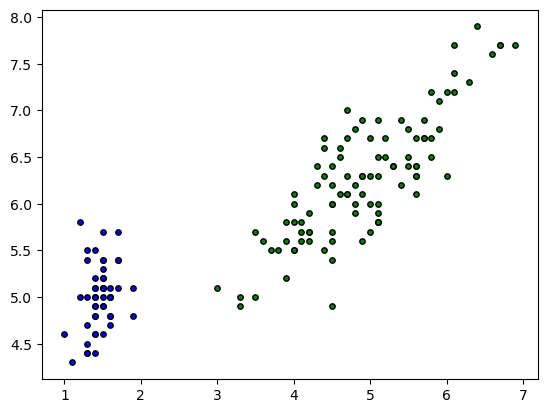

In [135]:
# Визуализация данных
colors = "gb"
#X_viz = iris.data[:, [1,2]]
X_viz = iris_x_ds_lr[['petal length (cm)', 'sepal length (cm)']].values
y_viz = iris_x_ds_lr['target_bin'].values
n_classes = len(np.unique(y_viz))
for i, color in zip(range(n_classes), colors):
    idx = np.where(y_viz == i)
    plt.scatter(X_viz[idx, 0], X_viz[idx, 1], 
                c=color, 
                cmap=plt.cm.RdYlBu, 
                edgecolor='black', s=15)
plt.show()    

In [136]:
# Реализация градиентного спуска
def sigmoid(x):
    '''
    Функция - сигмоида
    '''
    return 1 / (1 + np.exp(-x))

def proba(b, x):
    '''
    Вероятность единичного класса
    '''
    return sigmoid(np.dot(x,b))

def cost_function(b, x, y):
    '''
    Функция потерь
    '''
    k = x.shape[0]
    res = -(1 / k) * np.sum(
        y * np.log(proba(b, x)) 
        + (1 - y) * np.log(1 - proba(b, x)))
    return res

def gradient(b, x, y):
    '''
    Определение градиента
    '''
    k = x.shape[0]
    res = (1 / k) * np.dot(
        x.T, (proba(b, x) - y))

def optimize_lr(x, y, b):
    '''
    Для оптимизации используется функция 
    scipy.optimize.fmin_tnc
    '''
    opt_weights = fmin_tnc(
        func=cost_function, 
        x0=b,          
        fprime=gradient,
        approx_grad=True,
        args=(x, y))
    return opt_weights[0] 

In [138]:
opt_x = iris_x_ds_lr[['x0', 'petal length (cm)', 'sepal length (cm)']].values
opt_x[:5]

array([[1. , 1.4, 5.1],
       [1. , 1.4, 4.9],
       [1. , 1.3, 4.7],
       [1. , 1.5, 4.6],
       [1. , 1.4, 5. ]])

In [137]:
opt_y = iris_x_ds_lr['target_bin']
opt_y[:5]

0    1
1    1
2    1
3    1
4    1
Name: target_bin, dtype: int64

In [139]:
b_init = np.zeros(3)
b_init

array([0., 0., 0.])

In [142]:
b_res = optimize_lr(opt_x, opt_y, b_init)
b_res

C:\Users\kozlo\AppData\Local\Temp\ipykernel_13052\3126456101.py:21: RuntimeWarning: divide by zero encountered in log
  + (1 - y) * np.log(1 - proba(b, x)))


array([ 12.29579508, -28.08669972,  11.06463771])

In [143]:
def vis_lr(b):
    '''
    Визуализация результата
    '''    
    colors = "gb"
    X_viz = iris_x_ds_lr[['petal length (cm)', 'sepal length (cm)']].values
    y_viz = iris_x_ds_lr['target_bin'].values
    n_classes = len(np.unique(y_viz))
    for i, color in zip(range(n_classes), colors):
        idx = np.where(y_viz == i)
        plt.scatter(X_viz[idx, 0], X_viz[idx, 1], 
                    c=color, 
                    cmap=plt.cm.RdYlBu, 
                    edgecolor='black', s=15)

    t1 = iris_x_ds_lr['petal length (cm)'].values    
    t2 = -((b[0]+np.dot(b[1], t1))/b[2])
    plt.plot(t1, t2, 'r', linewidth=2.0)   
    plt.show()    

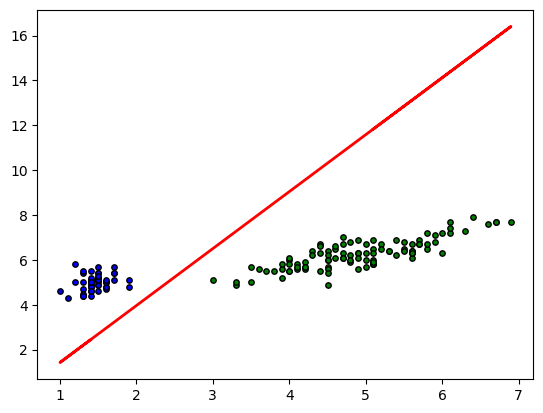

In [144]:
vis_lr(b_res)


In [145]:
from sklearn.linear_model import LogisticRegression
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(
    iris_x_ds_lr[['petal length (cm)', 'sepal length (cm)']].values, 
    iris_x_ds_lr['target_bin'].values, test_size=0.5, random_state=1)

In [147]:
cl1 = LogisticRegression()

In [148]:
cl1.fit(iris_X_train, iris_y_train)

LogisticRegression()

In [149]:
pred_iris_y_test = cl1.predict(iris_X_test)
pred_iris_y_test

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [150]:
pred_iris_y_test_proba = cl1.predict_proba(iris_X_test)
pred_iris_y_test_proba[:10]

array([[3.03551669e-02, 9.69644833e-01],
       [6.61038870e-01, 3.38961130e-01],
       [9.91453895e-01, 8.54610520e-03],
       [3.26584185e-02, 9.67341582e-01],
       [9.99963965e-01, 3.60350727e-05],
       [9.95340342e-01, 4.65965828e-03],
       [9.98647747e-01, 1.35225325e-03],
       [1.15108534e-01, 8.84891466e-01],
       [4.98014444e-02, 9.50198556e-01],
       [9.99690875e-01, 3.09124539e-04]])

In [151]:
# Вероятность принадлежности к 0 классу
[round(x, 4) for x in pred_iris_y_test_proba[:10,0]]

[0.0304, 0.661, 0.9915, 0.0327, 1.0, 0.9953, 0.9986, 0.1151, 0.0498, 0.9997]

In [152]:
# Вероятность принадлежности к 1 классу
[round(x, 4) for x in pred_iris_y_test_proba[:10,1]]

[0.9696, 0.339, 0.0085, 0.9673, 0.0, 0.0047, 0.0014, 0.8849, 0.9502, 0.0003]

In [154]:
accuracy_score(iris_y_test, pred_iris_y_test)

1.0

In [156]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))
print_accuracy_score_for_classes(iris_y_test, pred_iris_y_test)

Метка 	 Accuracy
0 	 1.0
1 	 1.0


# Метод опорных векторов.

# Деревья решений

In [106]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [107]:
iris_x_ds = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
iris_x_ds.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [108]:
def plot_tree_classification(title_param, ds):
    """
    Построение деревьев и вывод графиков для заданного датасета
    """
    
    n_classes = len(np.unique(ds.target))
    plot_colors = "ryb"
    plot_step = 0.02
    
    for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                    [1, 2], [1, 3], [2, 3]]):
        # We only take the two corresponding features
        X = ds.data[:, pair]
        y = ds.target

        # Train
        clf = DecisionTreeClassifier(random_state=1).fit(X, y)

        plt.title(title_param)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

        plt.xlabel(ds.feature_names[pair[0]])
        plt.ylabel(ds.feature_names[pair[1]])

        # Plot the training points
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=color, label=ds.target_names[i],
                        cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

        plt.show()    
    

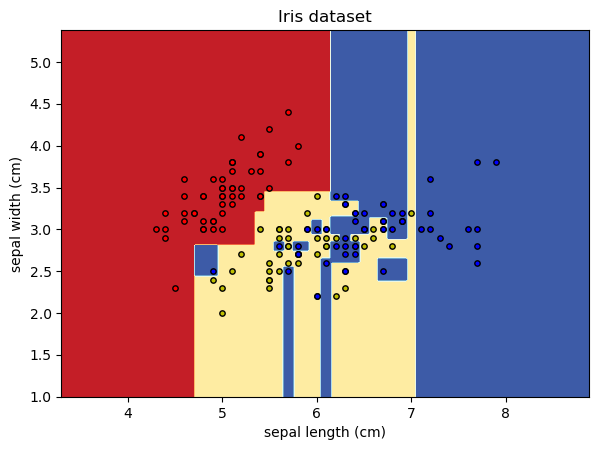

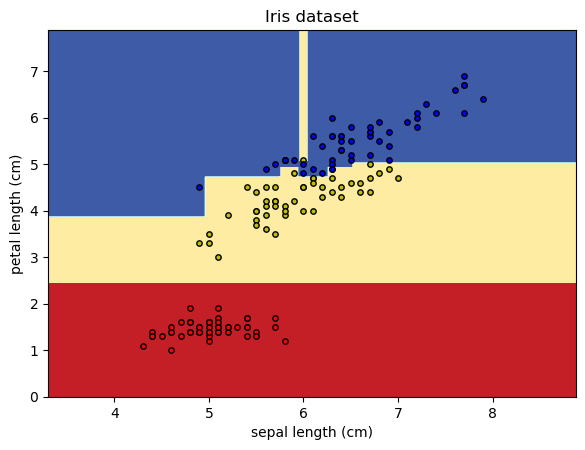

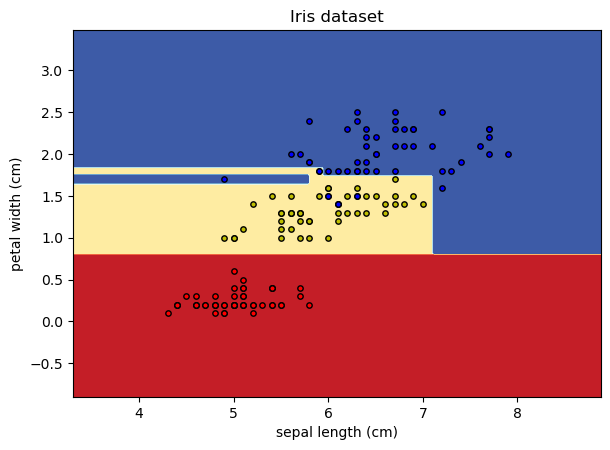

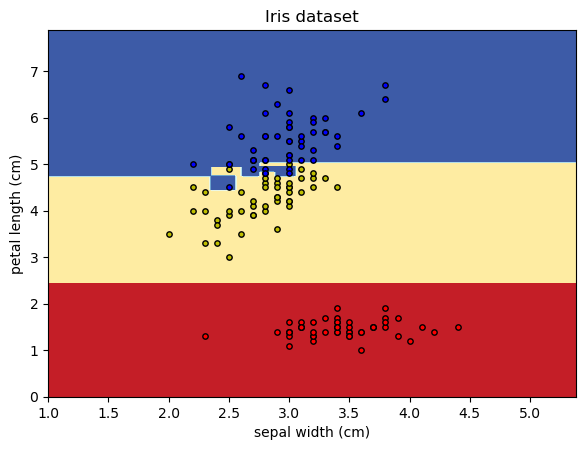

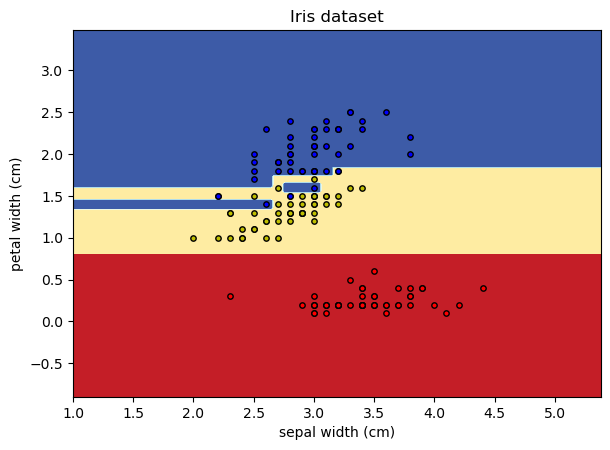

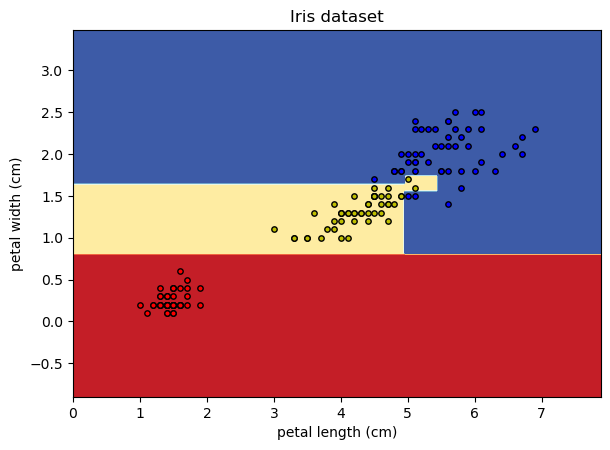

In [109]:
plot_tree_classification('Iris dataset', iris)

In [110]:
# Обучим дерево на всех признаках iris
iris_tree_cl = DecisionTreeClassifier(random_state=1)
iris_tree_cl.fit(iris_x_ds, iris.target)
iris_tree_cl

DecisionTreeClassifier(random_state=1)

In [111]:
DecisionTreeClassifier(random_state=1)

DecisionTreeClassifier(random_state=1)

__Вывод правил дерева в текстовом виде__

In [112]:
from IPython.core.display import HTML
from sklearn.tree import export_text
tree_rules = export_text(iris_tree_cl, feature_names=list(iris_x_ds.columns))
HTML('<pre>' + tree_rules + '</pre>')

In [113]:
# Важность признаков(в сумме = 1)
list(zip(iris_x_ds.columns.values, iris_tree_cl.feature_importances_))

[('sepal length (cm)', 0.026666666666666658),
 ('sepal width (cm)', 0.0),
 ('petal length (cm)', 0.05072262479871173),
 ('petal width (cm)', 0.9226107085346216)]

In [114]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

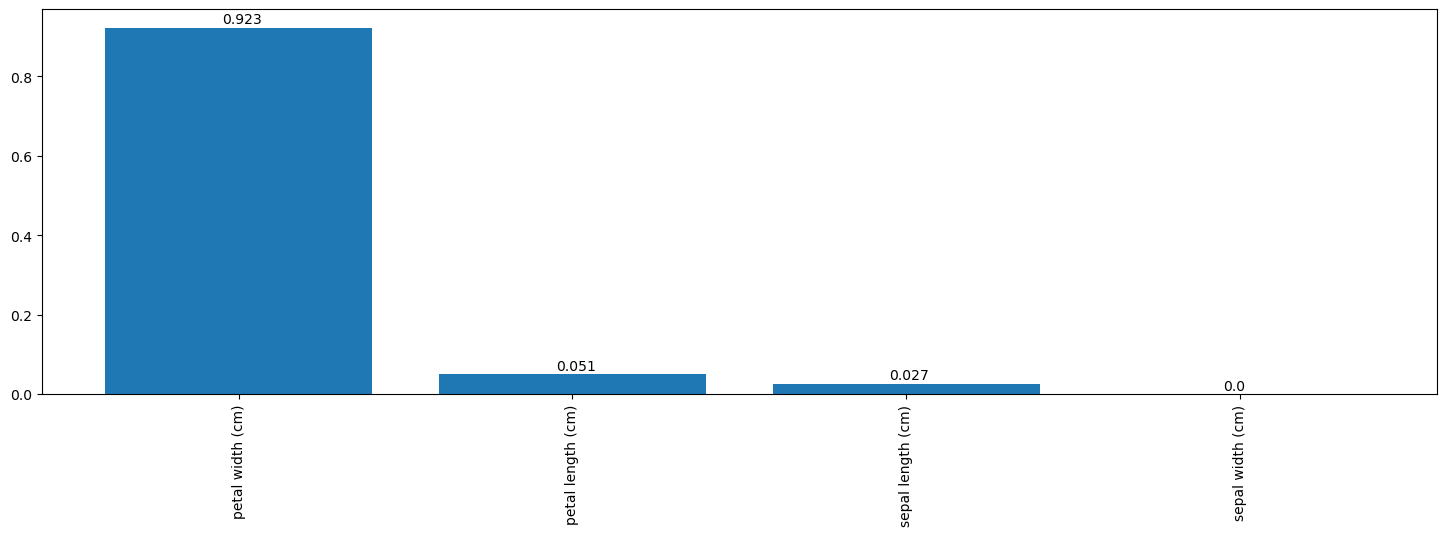

In [115]:
iris_tree_cl_fl, iris_tree_cl_fd = draw_feature_importances(iris_tree_cl, iris_x_ds)

In [116]:
# Разделим выборку на обучающую и тестовую
iris_x_ds_sorted = iris_x_ds[iris_tree_cl_fl]
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(
    iris_x_ds_sorted, iris.target, test_size=0.5, random_state=1)
iris_X_train.shape, iris_X_test.shape

((75, 4), (75, 4))

In [117]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [118]:
# Обучим дерево и предскажем результаты на всех признаках 
iris_tree_cl_feat_1 = DecisionTreeClassifier(random_state=1).fit(iris_X_train, iris_y_train)
iris_y_test_predict = iris_tree_cl_feat_1.predict(iris_X_test)
iris_y_test_predict.shape

(75,)

In [119]:
# Проверим точность по классам
print_accuracy_score_for_classes(iris_y_test, iris_y_test_predict)

Метка 	 Accuracy
0 	 1.0
1 	 1.0
2 	 0.7777777777777778


In [120]:
# Обучим дерево и предскажем результаты на единственном самом важном признаке 
iris_tree_cl_feat_2 = DecisionTreeClassifier(random_state=1).fit(iris_X_train[[iris_tree_cl_fl[0]]], iris_y_train)
iris_y_test_predict_2 = iris_tree_cl_feat_2.predict(iris_X_test[[iris_tree_cl_fl[0]]])
iris_y_test_predict_2.shape

(75,)

In [121]:
# Проверим точность по классам
print_accuracy_score_for_classes(iris_y_test, iris_y_test_predict_2)

Метка 	 Accuracy
0 	 1.0
1 	 0.9583333333333334
2 	 0.9629629629629629


### Гиперпараметры и борьба с переобучением

In [122]:
boston = load_boston()
df_boston = pd.DataFrame(boston.data,columns=boston.feature_names)
df_boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


d:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :fun

In [123]:
params = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [0.04, 0.06, 0.08],
    'max_features': [0.2, 0.4, 0.6, 0.8]
}

In [124]:
%%time
grid_1 = GridSearchCV(estimator=DecisionTreeRegressor(random_state=1),
                    param_grid=params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_1.fit(df_boston, boston.target)

Wall time: 4.51 s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [0.2, 0.4, 0.6, 0.8],
                         'min_samples_leaf': [0.04, 0.06, 0.08]},
             scoring='neg_mean_absolute_error')

In [125]:
%%time
grid_2 = GridSearchCV(estimator=DecisionTreeRegressor(random_state=1),
                    param_grid=params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_2.fit(df_boston, boston.target)

Wall time: 158 ms


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [0.2, 0.4, 0.6, 0.8],
                         'min_samples_leaf': [0.04, 0.06, 0.08]},
             scoring='neg_mean_squared_error')

In [126]:
-grid_1.best_score_, grid_1.best_params_

(3.926892662935901,
 {'max_depth': 4, 'max_features': 0.6, 'min_samples_leaf': 0.06})

In [127]:
-grid_2.best_score_, grid_2.best_params_

(32.18077135293171,
 {'max_depth': 4, 'max_features': 0.6, 'min_samples_leaf': 0.06})